# Seasonal Effects on Larceny Rates in Asheville

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as datetime

/Users/georgecollier/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import seaborn as sns

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [4]:
# s is our raw series of observations
s = pd.read_pickle('lar_series.pkl')

In [5]:
s.describe()

count           27657
unique             21
top       LARCENYFMMV
freq            11460
Name: offense_short_description, dtype: object

In [6]:
s.head()

incident_dt
2008-12-15 11:00:00          LARCFEL
2009-09-18 00:00:00    LARCENYFMBLDG
2009-10-01 00:00:00    LARCENYFMBLDG
2007-01-12 04:30:00      LARCENYFMMV
2012-07-26 00:00:00    LARCENYFMBLDG
Name: offense_short_description, dtype: object

In [7]:
X = s.resample('M').count()

In [8]:
X.sort_index(inplace=True)

In [9]:
X.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: offense_short_description, dtype: int64

In [10]:
print("dates run from {} to {}".format(X.index[0].date(), X.index[-1].date()))

dates run from 2005-01-31 to 2018-05-31


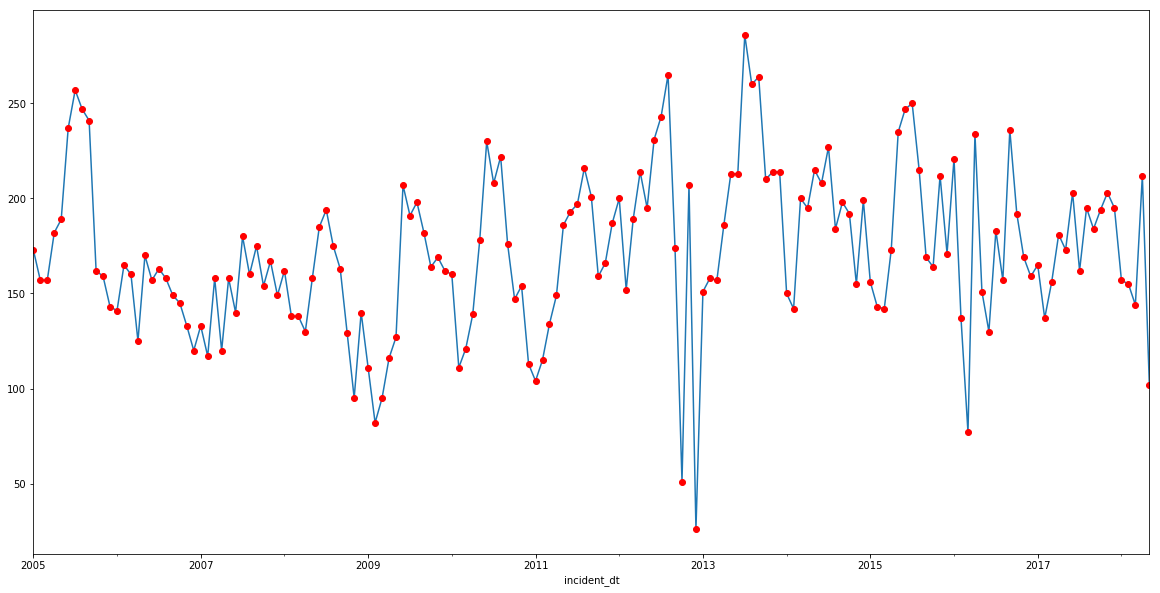

In [11]:
X.plot()
X.plot(style='ro')

_remove outliers_

In [12]:
m = X.mean()
sd = X.std()

In [13]:
cut = 2 # number of sd to cut at

In [14]:
X2 = pd.Series(X).where(lambda x : x > m - cut * sd).fillna(method='bfill')

In [15]:
X2 = pd.Series(X2).where(lambda x : x < m + cut * sd).fillna(method='bfill')

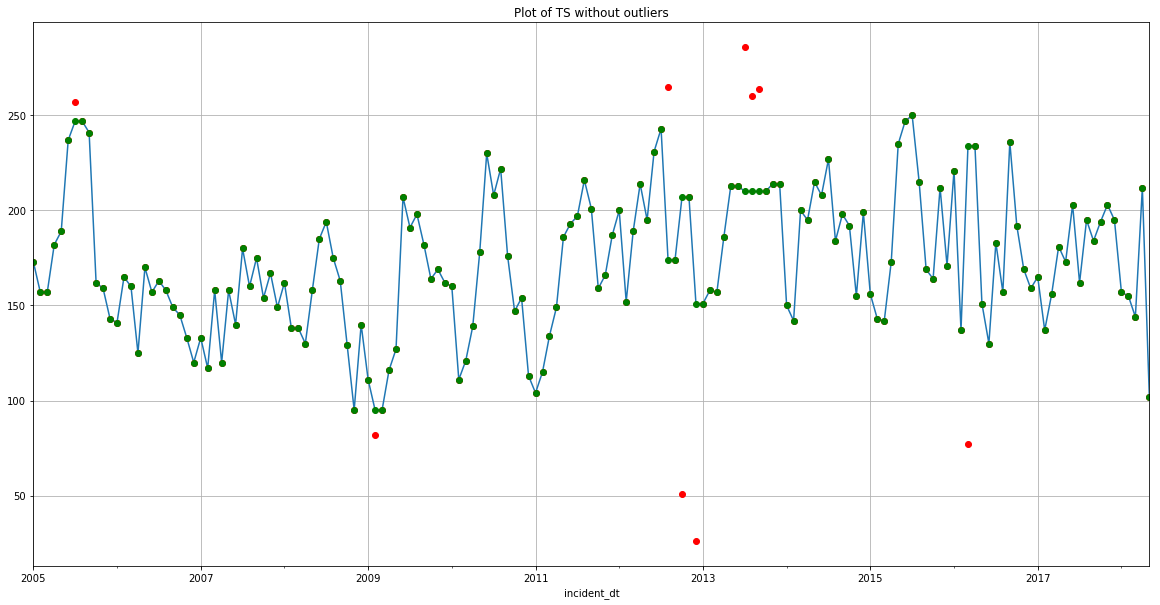

In [16]:
X2.plot(title='Plot of TS without outliers')
X.plot(style='ro')
X2.plot(style='go', grid=True)

In [17]:
s_model = seasonal_decompose(X, model='additive')

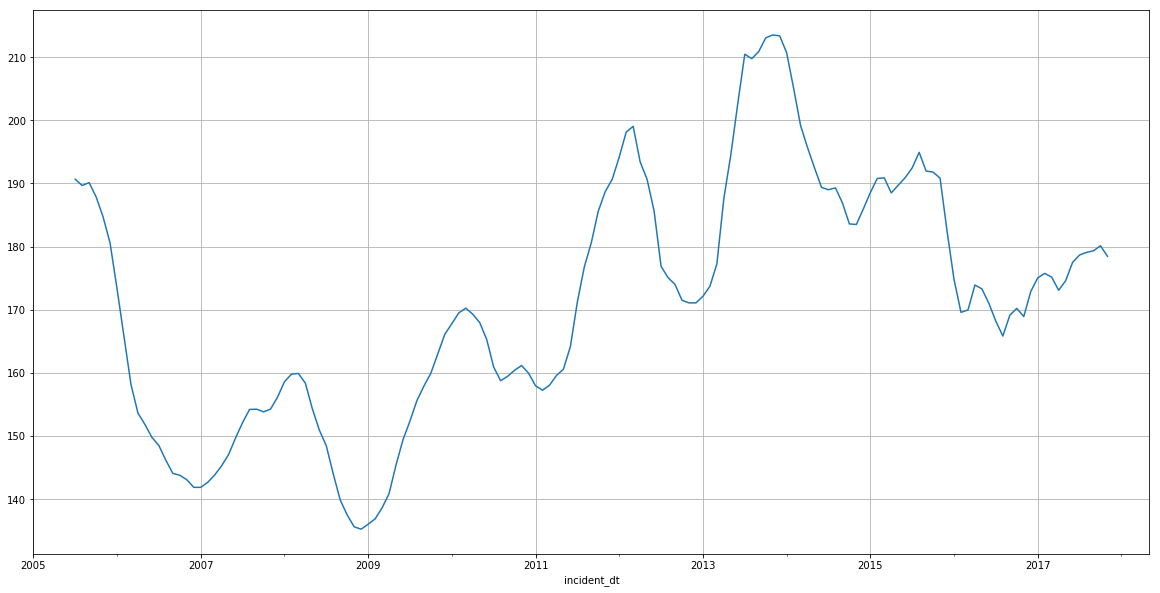

In [44]:
s_model.trend.plot(grid=True)

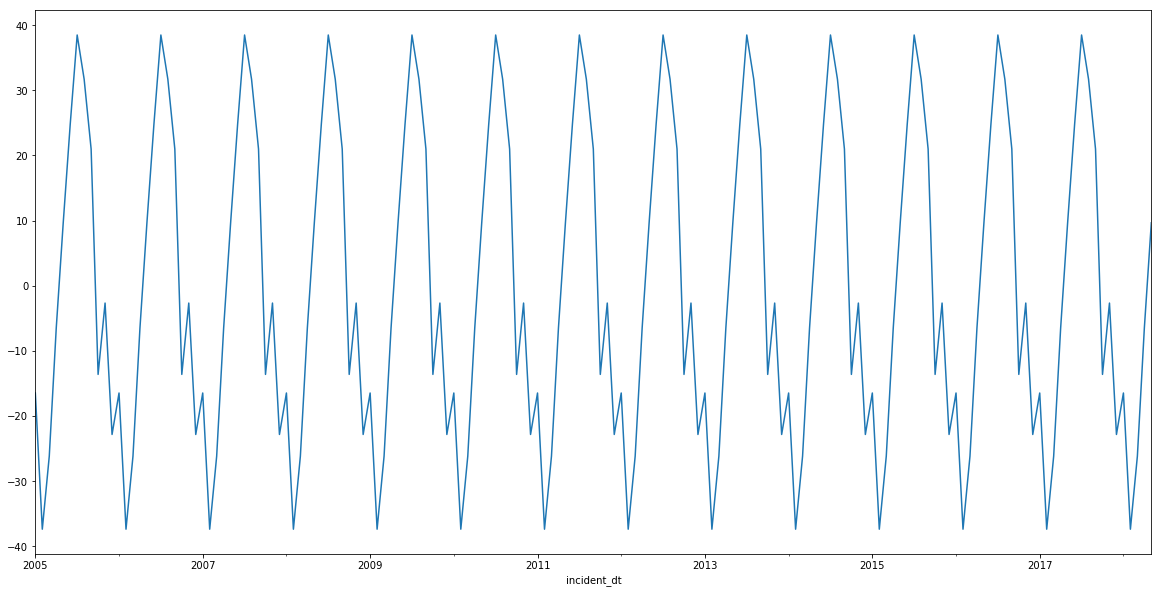

In [19]:
s_model.seasonal.plot()

In [20]:
s_high = s_model.seasonal.sort_values(ascending=False).head(5).mean()
s_low = s_model.seasonal.sort_values(ascending=True).head(5).mean()
print("seasonal effect is from {} to {}".format(s_low, s_high))

seasonal effect is from -37.3720619658 to 38.4922542735


In [21]:
res = s_model.seasonal.to_frame()
res.columns = ['seasonal']
res['trend'] = s_model.trend
res['pred'] = res['trend'] + res['seasonal']
res['actual'] = X2

In [22]:
# res.head(20)

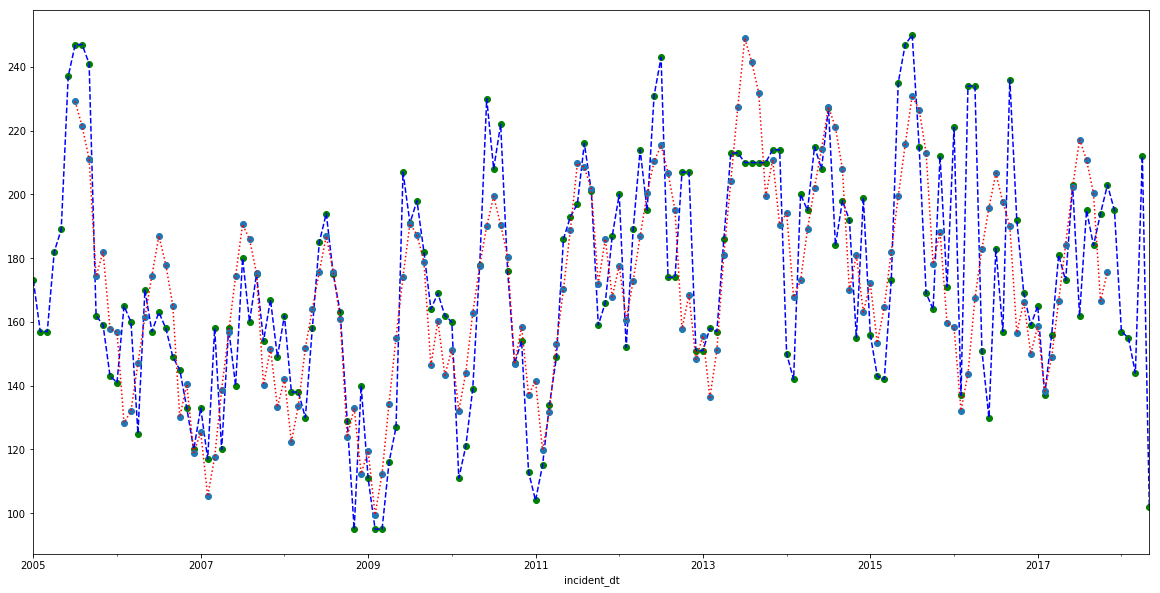

In [23]:
res['actual'].plot(style='go', sharex=True)
res['actual'].plot(color='blue', style='--', sharex=True)
res['pred'].plot(style='o')
res['pred'].plot(color='red', style=':', sharex=True)

In [24]:
year_07 = res['2007':'2010']

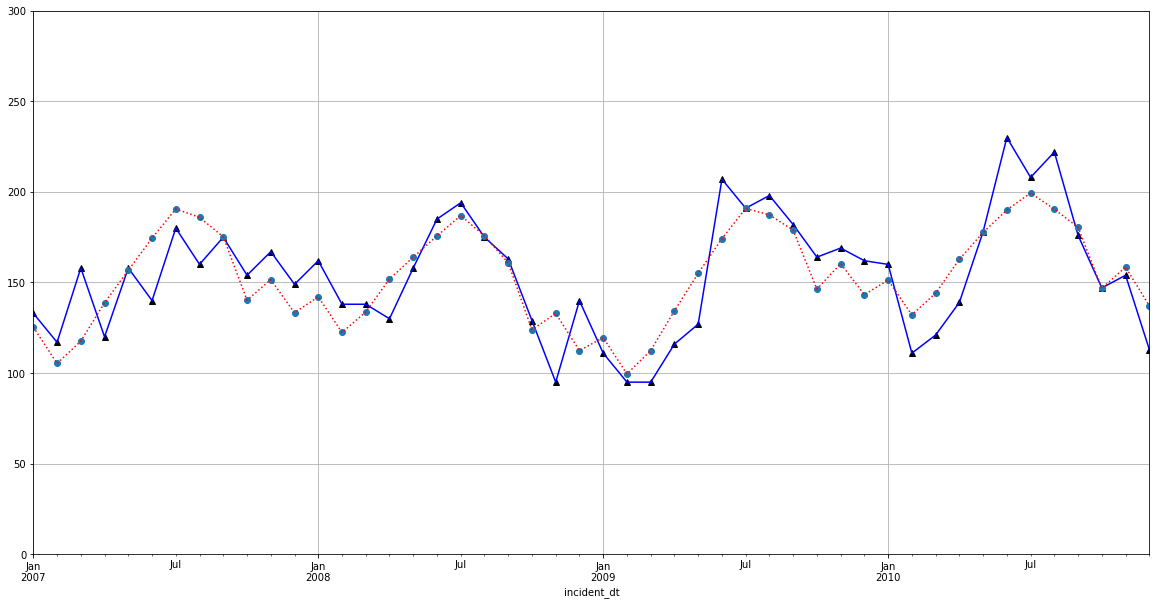

In [25]:
plt.ylim(0, 300)
year_07['actual'].plot(style='k^', sharex=True)
year_07['actual'].plot(color='blue', sharex=True)
year_07['pred'].plot(style='o')
year_07['pred'].plot(color='red', style=':', sharex=True, grid=True)

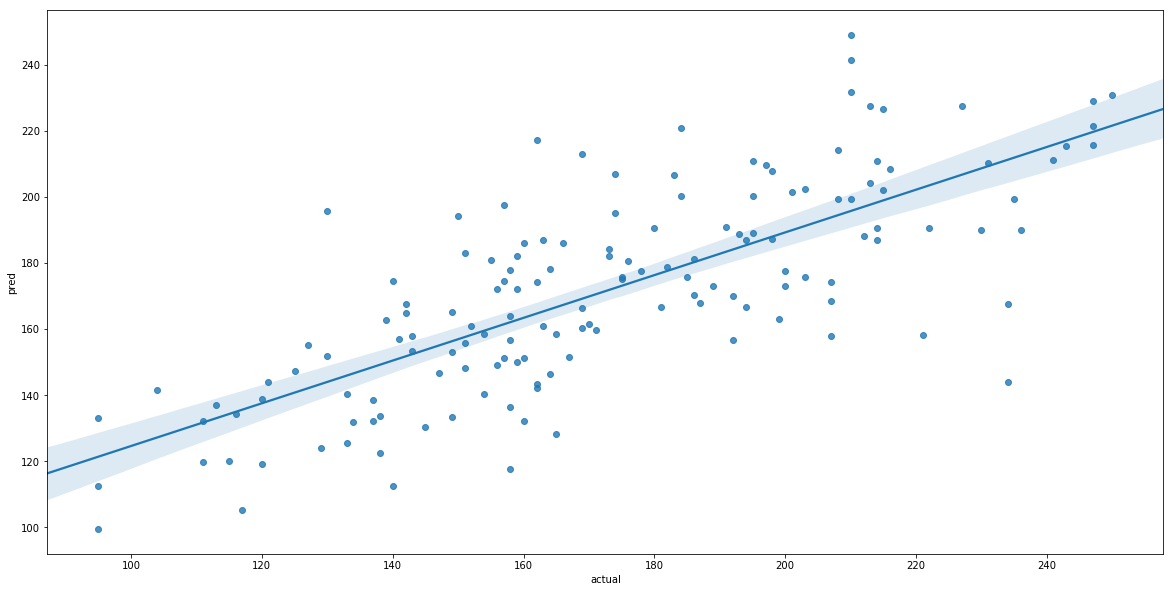

In [26]:
sns.regplot(x='actual', y='pred', data=res)

In [27]:
res_no_na = res.dropna()

In [28]:
model = sm.OLS(res_no_na['actual'], res_no_na['pred'])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 actual   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     7774.
Date:                Wed, 20 Jun 2018   Prob (F-statistic):          8.06e-130
Time:                        22:44:54   Log-Likelihood:                -685.81
No. Observations:                 149   AIC:                             1374.
Df Residuals:                     148   BIC:                             1377.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pred           1.0025      0.011     88.169      0.0

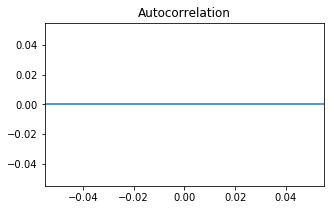

In [29]:
plt.rcParams['figure.figsize'] = (5.0, 3.0)
fig = plot_acf(res['trend'])

In [30]:
post_bc = X2[datetime.datetime(2013, 9, 1):]

In [31]:
len(post_bc)

57

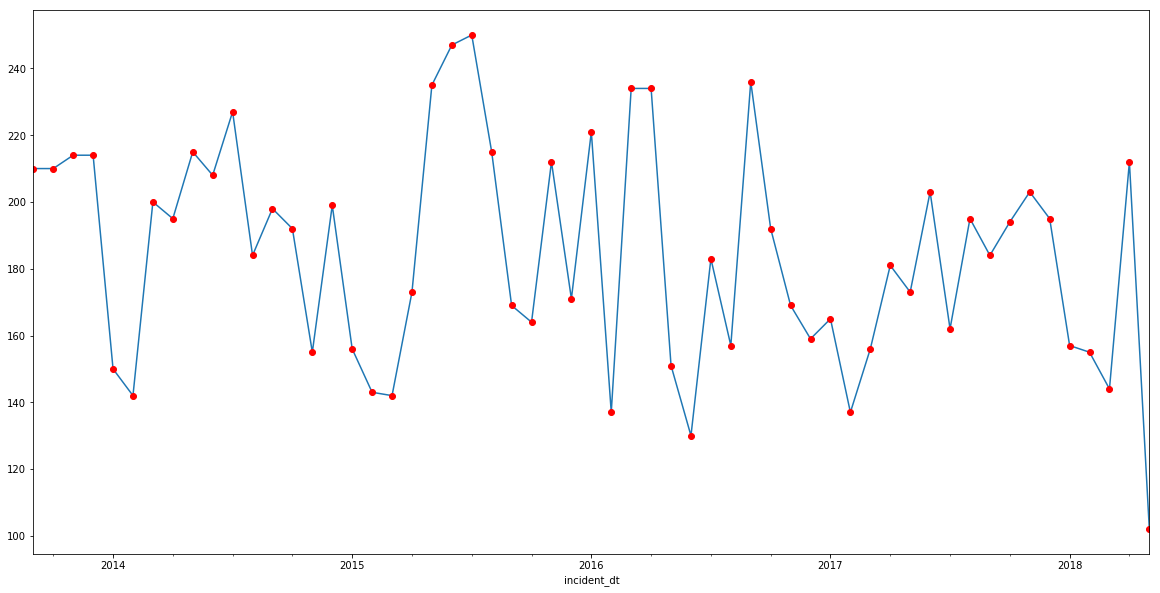

In [32]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
post_bc.plot()
post_bc.plot(style='ro')

In [33]:
s_post_bc = seasonal_decompose(post_bc)

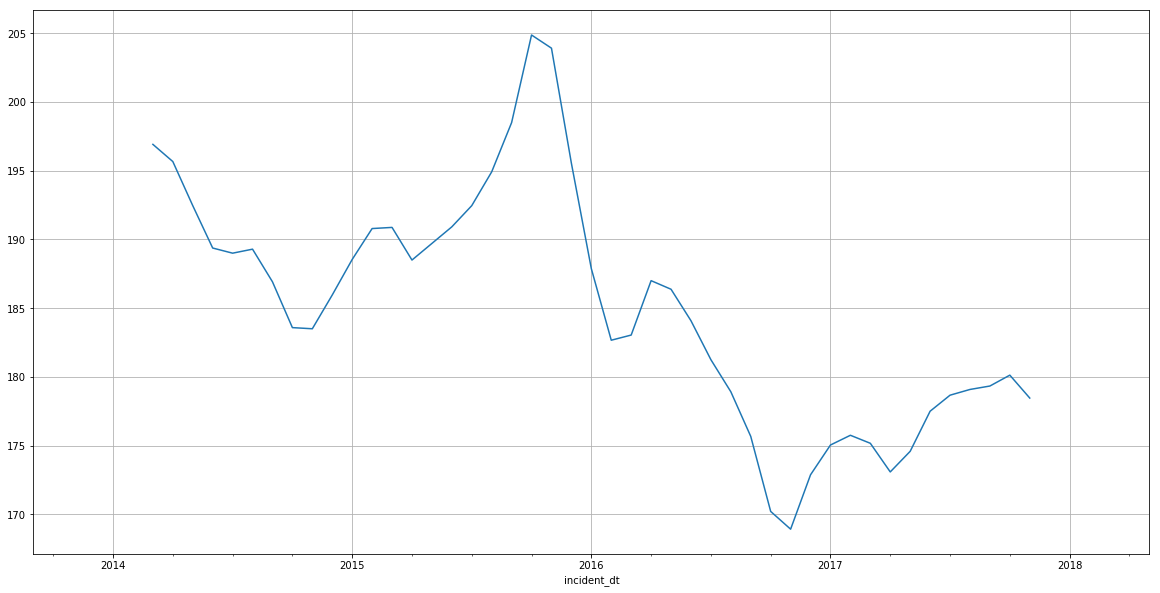

In [34]:
s_post_bc.trend.plot(grid=True)

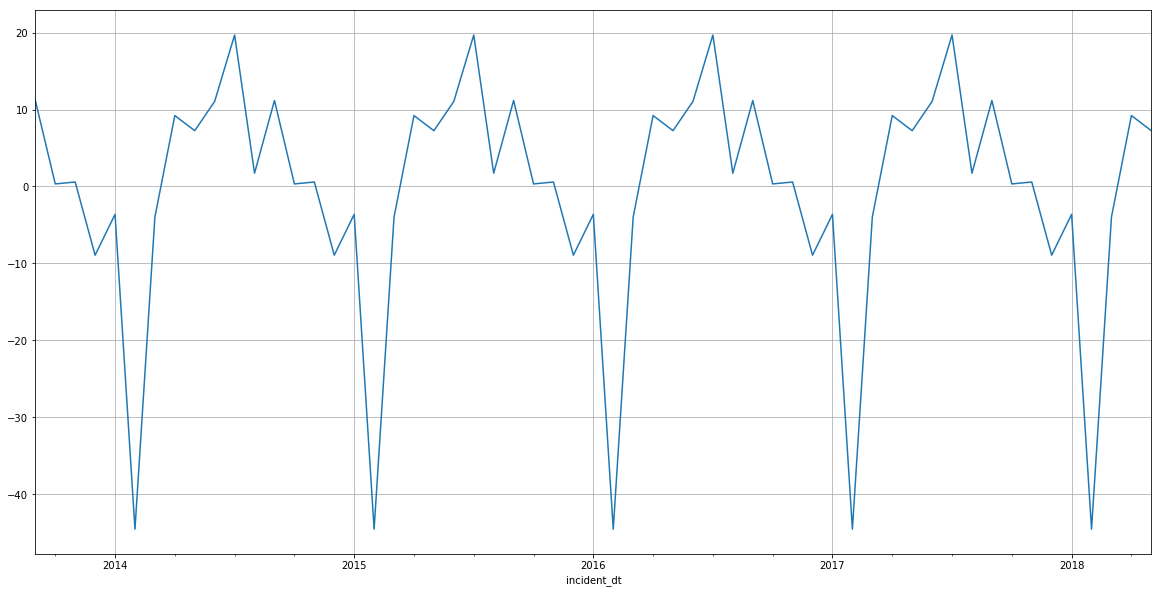

In [35]:
s_post_bc.seasonal.plot(grid=True)

In [36]:
post_bc_s_high = s_post_bc.seasonal.sort_values(ascending=False).head(5).mean()
post_bc_s_low = s_post_bc.seasonal.sort_values(ascending=True).head(5).mean()
print("post BC seasonal effect is from {} to {}".format(post_bc_s_low, post_bc_s_high))

post BC seasonal effect is from -44.537037037 to 17.9865740741


In [37]:
s_post_bc.seasonal.max()-s_post_bc.seasonal.min()

64.225694444444429

In [38]:
res2 = s_post_bc.seasonal.to_frame()
res2.columns = ['seasonal']

res2['trend'] = s_post_bc.trend

res2['pred'] = res2['trend'] + res2['seasonal']

res2['actual'] = post_bc

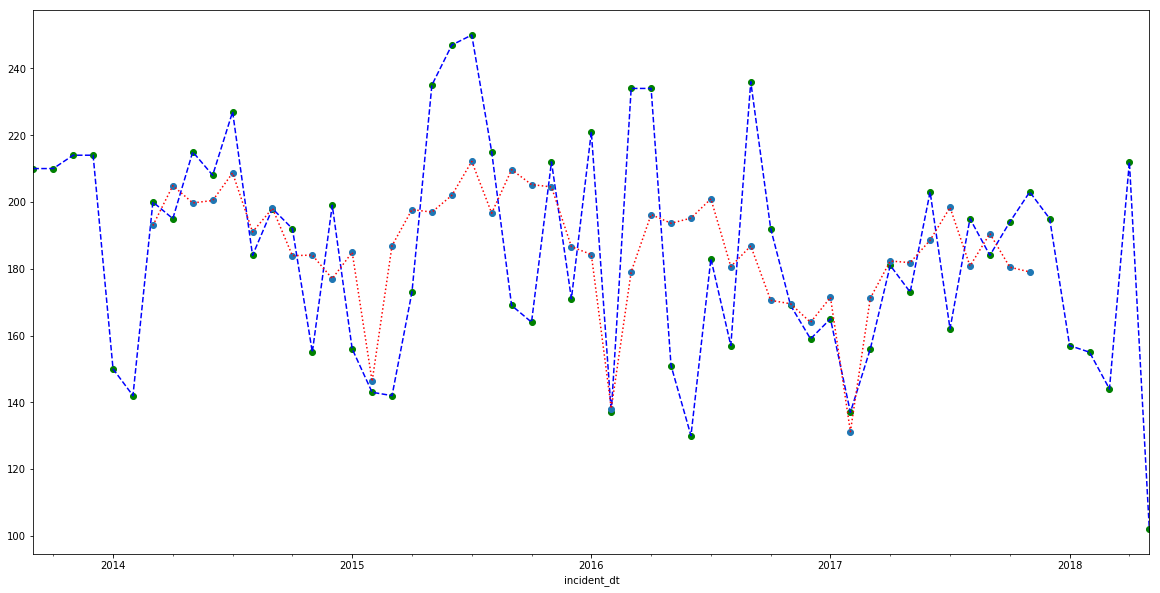

In [39]:
res2['actual'].plot(style='go', sharex=True)
res2['actual'].plot(color='blue', style='--', sharex=True)
res2['pred'].plot(style='o')
res2['pred'].plot(color='red', style=':', sharex=True)

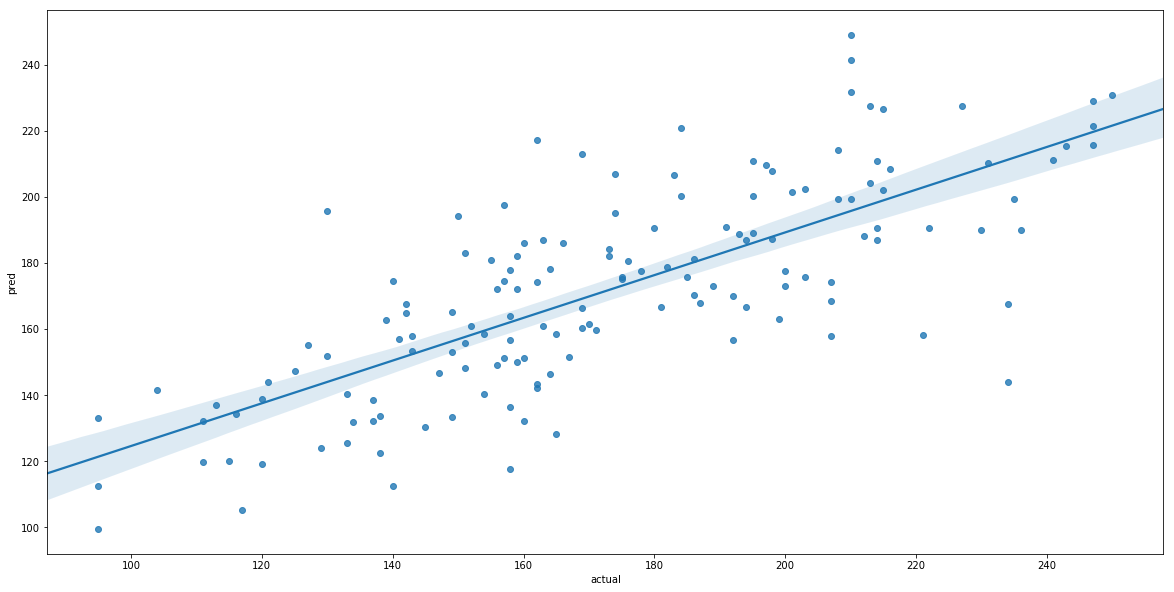

In [40]:
sns.regplot(x='actual', y='pred', data=res)

In [42]:
post_bc_res_no_na = res2.dropna()

In [43]:
model = sm.OLS(post_bc_res_no_na['actual'], post_bc_res_no_na['pred'])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 actual   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2100.
Date:                Wed, 20 Jun 2018   Prob (F-statistic):           8.95e-39
Time:                        22:46:45   Log-Likelihood:                -212.39
No. Observations:                  45   AIC:                             426.8
Df Residuals:                      44   BIC:                             428.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pred           1.0018      0.022     45.824      0.0